# **Overview of MPOPT**
(c) 2023 Devakumar Thammisetty

MPOPT is an open-source Multi-phase Optimal Control Problem (OCP) solver based on pseudo-spectral collocation with customized adaptive grid refinement techniques.

https://mpopt.readthedocs.io/

Download this notebook: [getting_started.ipynb](https://github.com/mpopt/mpopt/blob/docs/docs/source/notebooks/getting_started.ipynb)

Tip: Ctrl + Tab (For the documentation of commands/syntax)

Install mpopt from pypi using the following. Disable after first usage

In [2]:
#pip install mpopt

Import mpopt (Contains main solver modules)

In [3]:
# from context import mpopt
from mpopt import mp

## Defining OCP

We first create an OCP object and then polulate the object with dynamics, path_constraints, terminal_constraints and objective (running_costs, terminal_costs)
* create an OCP object (Lets define moon-lander OCP)

In [4]:
ocp = mp.OCP(n_states=2, n_controls=1, n_phases=1)

* Add dynamics to the OCP. The solver being multi-phase, we add phase index to dynamics definition. 

#### Moon lander (2D)

$ \dot{x} = v; \quad \dot{v} = u - g$

* Using the standard Bolza form of OCP,
$\dot{x} = f(x, u, t) \quad \implies$

In [5]:
ocp.dynamics[0] = lambda x, u, t: [x[1], u[0] - 1.5]

* Add objective function, Lets get fuel optimal solution (u : Thrust level), Using standard Bolza form

$ J = 0 + \int_{t_0}^{t_f} u dt $

In [6]:
ocp.running_costs[0] = lambda x, u, t: u[0]

* Add terminal constraints. The target is to reach (postion : 0, velocity : 0), Using standard terminal constraints function

$h(x_f, t_f, x_0, t_0) = 0 $

In [7]:
ocp.terminal_constraints[0] = lambda xf, tf, x0, t0: [xf[0], xf[1]]

* Define starting position and initial velocity

$x[phase]$

In [8]:
ocp.x00[0] = [10.0, -2.0]

* Thrust is constrained between 0 and 3. 
$ \implies 0 \leq u \leq 3$

In [9]:
ocp.lbu[0], ocp.ubu[0] = 0, 3

* Validate if the ocp is well defined

In [10]:
ocp.validate()

### Solve and plot the results in one line

Lets solve the OCP using following pseudo-spectral approximation
* Collocation using Legendre-Gauss-Radau roots
* Global collocation (single segment)
* Let's plot the position and velocity evolution with time starting from 0.

The OCP is a free final time formulation, 


 *********** MPOPT Summary ********** 


CasADi - 2024-03-10 12:06:39 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


 Optimal cost (J):  8.27612 

 Solved in 343.132 ms
 	 OCP transcription time  : 322.33 ms
 	 NLP solution time       : 20.802 ms

 Post processed in 45.493 ms
 	 Solution retrieval            : 0.126 ms
 	 Residual in dynamics           : 6.594 ms
 	 Process solution and plot      : 38.773 ms


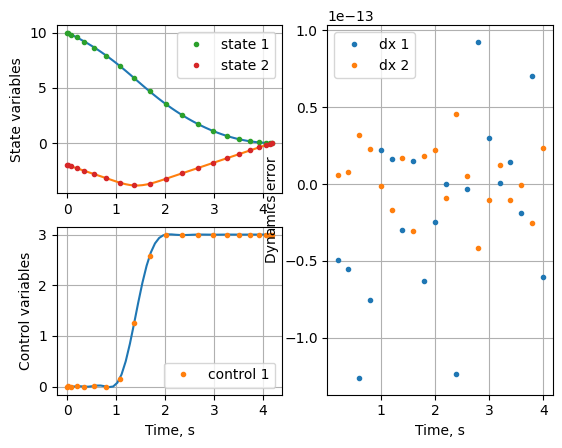

In [11]:
mpo, post = mp.solve(ocp, n_segments=1, poly_orders=20, scheme="LGR", plot=True)

The tics in the solution represent the values at collocation nodes. The states and controls are plotted by interpolating the lagrange polynomials at only few points in a single segment (by default). Let's interpolate with better resolution for plotting.

In [12]:
post._INTERPOLATION_NODES_PER_SEG = 200

Lets plot the same result again, this time the control profile is more refined. 

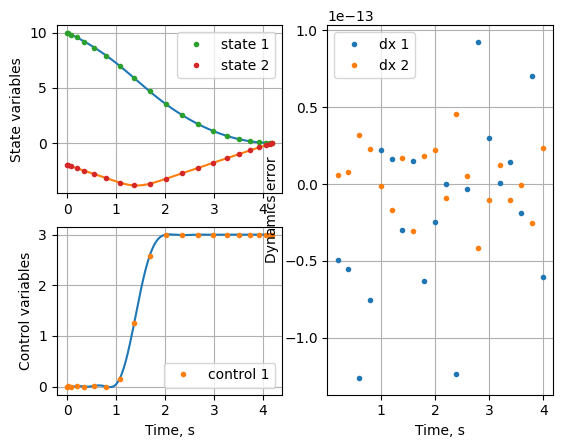

In [13]:
fig, axs = post.plot_phases()

Lets retrive the solution to see the terminal time

In [14]:
x, u, t, _ = post.get_data()

Last element of t and x gives the terminal values. Exact terminal time from the analytical solution is 4.1641s.

In [15]:
print(f"Terminal time, state : {t[-1]}, {x[-1]}")

Terminal time, state : [4.18408515], [-6.22886168e-26  2.27628981e-25]


The Fuel optimal solution to the moon-lander OCP is known to have bang-bang thrust profile. The selected OCP has one discontinuity. To better appoximate the solution, we can divide the domain into multiple segments.

Lets solve the problem now using better collocation approximation, based on the bang-nag nature of the thrust profile.
* Number of segments : 20
* Polynomials of degree : 3


 *********** MPOPT Summary ********** 

 Optimal cost (J):  8.24677 

 Solved in 45.279 ms
 	 OCP transcription time  : 21.198 ms
 	 NLP solution time       : 24.081 ms

 Post processed in 60.651 ms
 	 Solution retrieval            : 0.312 ms
 	 Residual in dynamics           : 10.062 ms
 	 Process solution and plot      : 50.278 ms


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


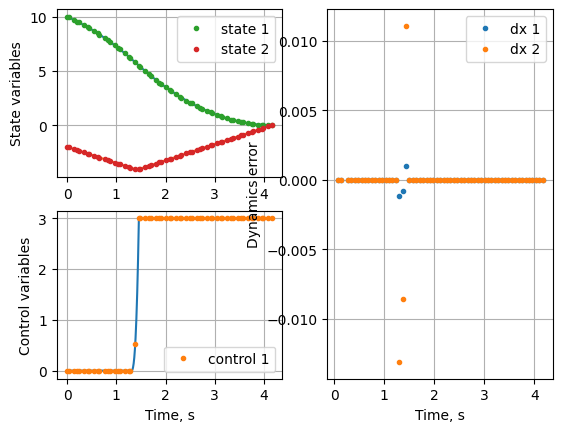

In [16]:
mpo, post = mp.solve(ocp, n_segments=20, poly_orders=3, scheme="LGR", plot=True)

The solution is now more refined. Lets look at the terminal time.

In [17]:
print(f"Terminal time, s : {post.get_data()[-2][-1][0]} vs 4.1641")

Terminal time, s : 4.164513728300145 vs 4.1641


Let's find the best solution by increasing the collocation nodes

In [18]:
mpo, post = mp.solve(ocp, n_segments=200, poly_orders=3, scheme="LGR", plot=False)
print(f"\nTerminal time, s : {post.get_data()[-2][-1][0]} vs 4.1641")


 *********** MPOPT Summary ********** 
 Optimal cost (J):  8.24623 

 Solved in 431.338 ms
 	 OCP transcription time  : 242.666 ms
 	 NLP solution time       : 188.672 ms

 Post processed in 181.282 ms
 	 Solution retrieval            : 0.702 ms
 	 Residual in dynamics           : 180.57 ms
 	 Process solution and plot      : 0.009 ms

Terminal time, s : 4.164150730471649 vs 4.1641


Let's check how the Legendre-Gauss-Lobatto roots solve the OCP


 *********** MPOPT Summary ********** 
 Optimal cost (J):  6.87196 

 Solved in 496.378 ms
 	 OCP transcription time  : 230.422 ms
 	 NLP solution time       : 265.956 ms

 Post processed in 362.558 ms
 	 Solution retrieval            : 0.871 ms
 	 Residual in dynamics           : 154.644 ms
 	 Process solution and plot      : 207.043 ms

Terminal time using Lobatto roots , s : 4.723467249086362 vs 4.1641


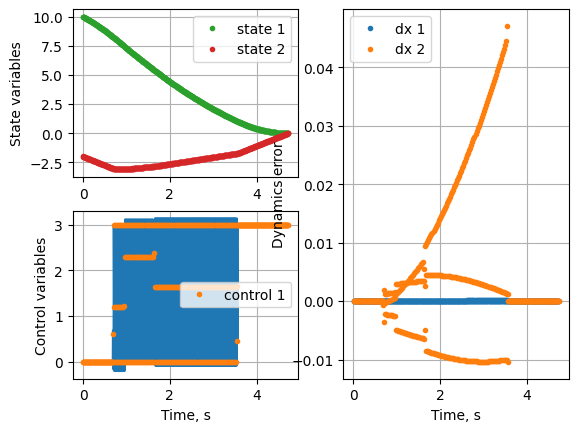

In [19]:
mpo, post = mp.solve(ocp, n_segments=200, poly_orders=3, scheme="LGL", plot=True)
print(f"\nTerminal time using Lobatto roots , s : {post.get_data()[-2][-1][0]} vs 4.1641")

Pretty bad result, huh!. The thrust profile is not smooth. Besides, so many number of segments. Lobatto roots lead to better convergence when the degree of the polynomial is higher.

### Adding additional constraints to the OCP

Let's constrain the derivative of control between $\pm 1$.

$-1 \leq \dot{u} \leq 1$

* Enable the differential constraint
* Choose bounds of the control slope

In [20]:
ocp.diff_u[0] = 1
ocp.lbdu[0], ocp.ubdu[0] = -1, 1

Let's solve again by adding the above constraint.


 *********** MPOPT Summary ********** 

 Optimal cost (J):  8.1831 

 Solved in 107.721 ms
 	 OCP transcription time  : 66.337 ms
 	 NLP solution time       : 41.384 ms

 Post processed in 20.4 ms
 	 Solution retrieval            : 0.17 ms
 	 Residual in dynamics           : 20.223 ms
 	 Process solution and plot      : 0.007 ms

Terminal time using Lobatto roots , s : 4.181973552017326 vs 4.1641


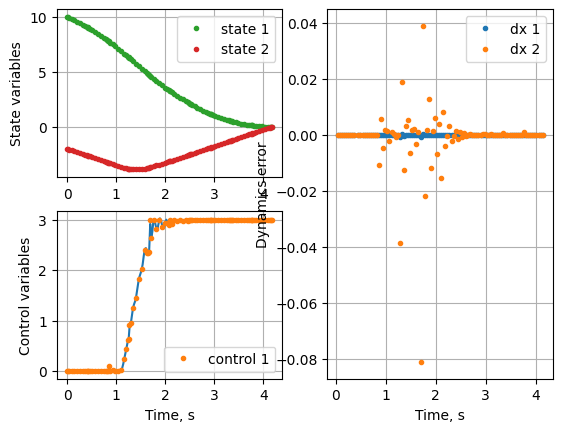

In [21]:
mpo, post = mp.solve(ocp, n_segments=10, poly_orders=10, scheme="LGL", plot=False)
post._INTERPOLATION_NODES_PER_SEG = 20
post.plot_phases()
print(f"\nTerminal time using Lobatto roots , s : {post.get_data()[-2][-1][0]} vs 4.1641")

Change the number of semgents and approximating to see how the solution behaves.

Disable the slope constraint for further calculations. Also, Radau roots are found to be approximating the given solution best!

In [22]:
ocp.diff_u[0] = 0

Let's see what happens if we increase the polynomial degree to 25.


 *********** MPOPT Summary ********** 
 Optimal cost (J):  8.24747 

 Solved in 1750.149 ms
 	 OCP transcription time  : 1589.343 ms
 	 NLP solution time       : 160.807 ms

 Post processed in 123.729 ms
 	 Solution retrieval            : 0.197 ms
 	 Residual in dynamics           : 123.524 ms
 	 Process solution and plot      : 0.008 ms

Terminal time using Radau roots , s : 4.164977321911994 vs 4.1641


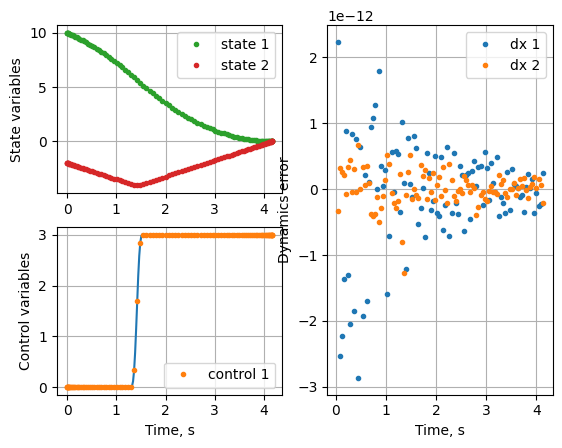

In [23]:
mpo, post = mp.solve(ocp, n_segments=1, poly_orders=100, scheme="LGR", plot=False)
post._INTERPOLATION_NODES_PER_SEG = 200
post.plot_phases()
print(f"\nTerminal time using Radau roots , s : {post.get_data()[-2][-1][0]} vs 4.1641")

The derivative and interpolation matrices are evaluated using CasADi algorithmic differentiation. Hence, high values of polynomial order such as 100 are feasible.

On the contrary, if the derivative operators are contructed using numpy's polynomial module, as the number of nodes increases, numerical noise builds up in the D matrix approximation leading to unstable solution. 

## Adaptive grid refinement schemes

A good guess of the number of segments and polynomial order are necessary to get exact solution. However, adaptive grid refinement techniques solve this problem by relocating the collocation points.

There are three inbuit refinement schemes in the package. First two are iterative. Refer theis for the exact details of implementaion.

The schemes are named as follows
* Adaptive_h_refinement (Iterative)
  * Scheme-1: Based on control slope
  * Scheme-2: Based on residual in dynamics
* Scheme-3: Direct optimization of segment widths (h)

Let's see how grid refinement changes the solution to moon-lander OCP

Let's create the optimizer object

In [24]:
mpo = mp.mpopt_h_adaptive(ocp, 10, 4) # Use ctrl + tab for help, inside ()

## Adaptive scheme-I

Let's solve the OCP using scheme 1. Let's limit the maximum iterations to 1. (Same as non-adaptive solution)

* control_slope

In [25]:
solution = mpo.solve(max_iter=1, mpopt_options={'method':'control_slope'})


 *********** MPOPT H-Adaptive Summary ********** 

Stopping the iterations: Iteration limit exceeded
H-Adaptive Iter., max_residual : 1, 0.03650101311435586
 Optimal cost (J):  8.24933 

 Solved in 48.449 ms


Let's process the solution and plot states and controls. This solution is same as the non-adaptive solution, since the max iterations are set to 1.


 Post processed in 39.596 ms
 	 Solution retrieval            : 0.124 ms
 	 Residual in dynamics           : 7.045 ms
 	 Process solution and plot      : 32.427 ms


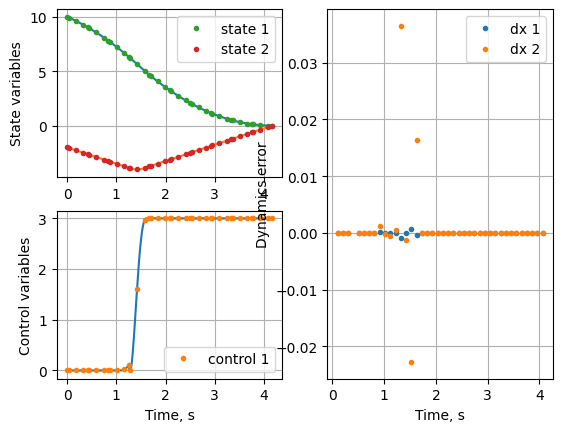

In [26]:
post = mpo.process_results(solution, plot=True)

Let's increase the number of iterations and see how the grid refinement works. Let's enable the residual plot as well.


 *********** MPOPT H-Adaptive Summary ********** 

Iteration : 1, 0.03650101311435586
Solved phase 0 to acceptable level 0.01, residual: 0.008459852092415718
Solved to acceptable tolerance 0.01 0.008459852092415718
H-Adaptive Iter., max_residual : 2, 0.008459852092415718
 Optimal cost (J):  8.24648 

 Solved in 54.261 ms


 Post processed in 52.279 ms
 	 Solution retrieval            : 0.094 ms
 	 Residual in dynamics           : 6.343 ms
 	 Process solution and plot      : 45.842 ms


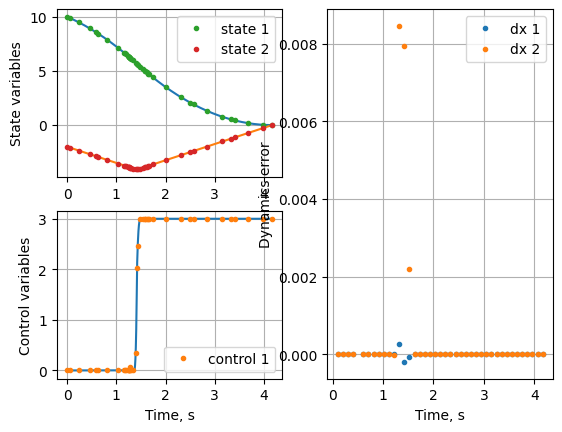

In [27]:
max_iter = 2
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'control_slope'})
post = mpo.process_results(solution, plot=True)

Note that the grid is refine with more points towards the discontinuity in one iteration. Let's check the terminal time.

In [28]:
print(f"\nTerminal time using Adaptive +{max_iter-1} iteration , s : {round(post.get_data()[-2][-1][0], 4)} vs 4.1641")


Terminal time using Adaptive +1 iteration , s : 4.1643 vs 4.1641


Let's further increase the iterations and check the final result on convergence. 


 *********** MPOPT H-Adaptive Summary ********** 

Iteration : 1, 0.03650101311435586
Solved phase 0 to acceptable level 0.01, residual: 0.008459852092415718
Solved to acceptable tolerance 0.01 0.008459852092415718
H-Adaptive Iter., max_residual : 2, 0.008459852092415718
 Optimal cost (J):  8.24648 

 Solved in 49.589 ms


 Post processed in 45.452 ms
 	 Solution retrieval            : 0.101 ms
 	 Residual in dynamics           : 6.546 ms
 	 Process solution and plot      : 38.805 ms


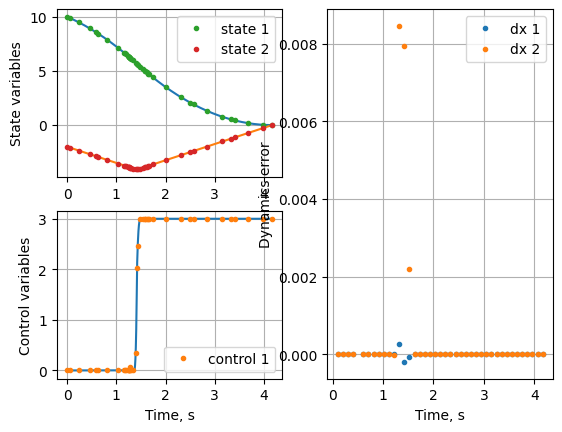

In [29]:
max_iter = 10
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'control_slope'})
post = mpo.process_results(solution, plot=True)

In [30]:
print(f"\nTerminal time using Adaptive +{max_iter-1} iteration , s : {round(post.get_data()[-2][-1][0], 4)} vs 4.1641")


Terminal time using Adaptive +9 iteration , s : 4.1643 vs 4.1641


The solution converged in 3 iterations and terminal time matches to 4 th digit with 40 nodes.

## Adaptive scheme-II

The method is based on the estimates of residual at the mid points of the collocation nodes. Further, two sub-methods are implemented in the software

* residual based
  * merge/split
  * equal residual segments

Let's solve the same OCP using Adaptive scheme-II. This time let's enable the residual evolution plots.

In [31]:
mpo = mp.mpopt_h_adaptive(ocp, 10, 4) # Use ctrl + tab for help, inside ()
mpo.plot_residual_evolution = True

**Submethod-1: merge/split**


 *********** MPOPT H-Adaptive Summary ********** 

Iteration : 1, 0.03650101311435586
Solved phase 0 to acceptable tolerance 0.01
Solved to acceptable tolerance 0.01 0.00022653276701605635
H-Adaptive Iter., max_residual : 2, 0.00022653276701605635
 Optimal cost (J):  8.24624 

 Solved in 83.772 ms


 Post processed in 42.848 ms
 	 Solution retrieval            : 0.129 ms
 	 Residual in dynamics           : 5.925 ms
 	 Process solution and plot      : 36.793 ms


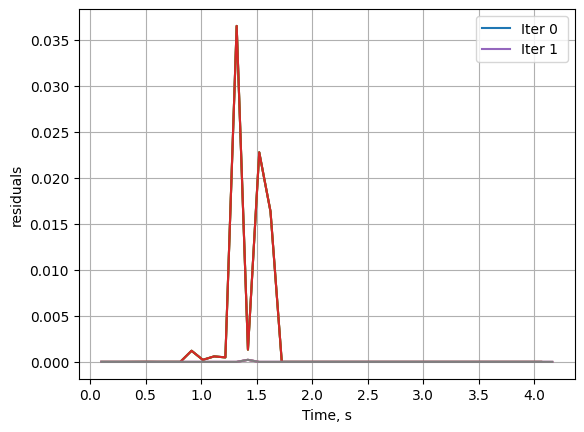

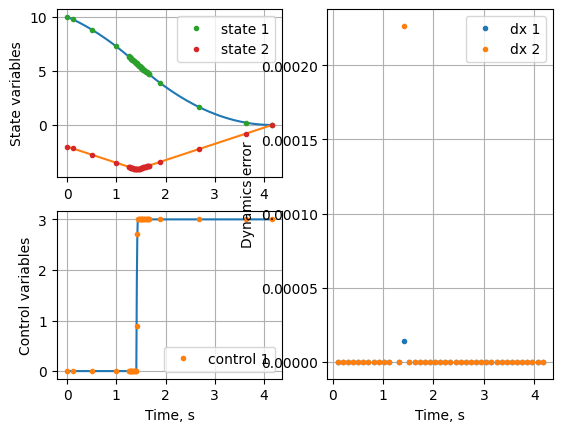

In [32]:
max_iter = 2
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'residual', 'sub_method':'merge_split'})
post = mpo.process_results(solution, plot=True)

Notice that the residual in the first iteration is higher towards the discontinuity. In the second iteration, the segments near the start and final times merged so that segments close to the discontinuity are split and the solution converged with in +1 iteration. 

The solution is close to the exact solution, lets look at the terminal time.

In [33]:
print(f"\nTerminal time using Adaptive-II scheme with +{max_iter-1} iterations , s : {post.get_data()[-2][-1][0]} vs 4.1641")


Terminal time using Adaptive-II scheme with +1 iterations , s : 4.16416187794445 vs 4.1641


Lets reduce the tolerance on the residual to see if the solution improves

In [34]:
mpo = mp.mpopt_h_adaptive(ocp, 10, 4) # Use ctrl + tab for help, inside ()
mpo.plot_residual_evolution = True
mpo.tol_residual[0] = 1e-4


 *********** MPOPT H-Adaptive Summary ********** 

Iteration : 1, 0.03650101311435586
Iteration : 2, 0.005345204401015982
Solved phase 0 to acceptable tolerance 0.0001
Solved to acceptable tolerance 0.0001 1.4089315576344685e-06
H-Adaptive Iter., max_residual : 3, 1.4089315576344685e-06
 Optimal cost (J):  8.24621 

 Solved in 92.315 ms


 Post processed in 49.622 ms
 	 Solution retrieval            : 0.104 ms
 	 Residual in dynamics           : 6.128 ms
 	 Process solution and plot      : 43.39 ms


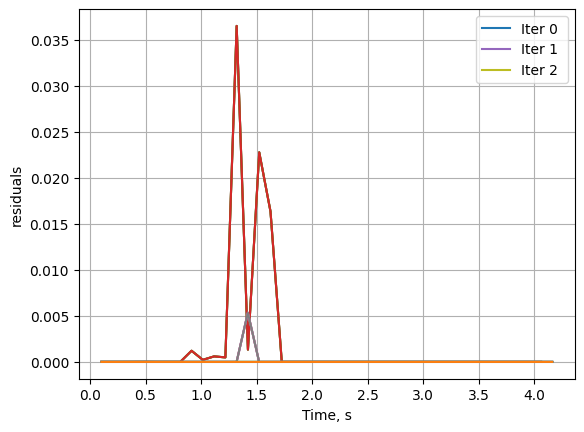

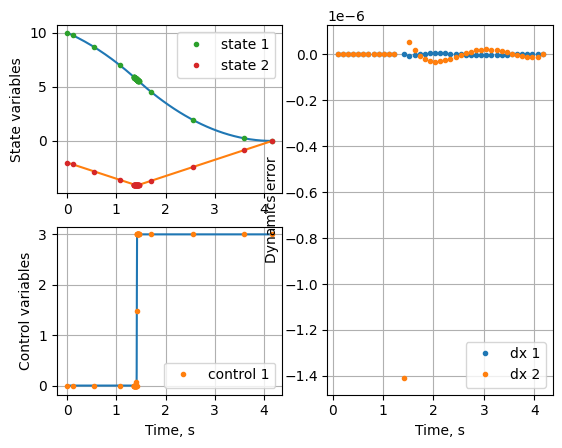

In [35]:
max_iter = 10
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'residual', 'sub_method':'merge_split'})
post = mpo.process_results(solution, plot=True)

The solution doesn't change after 1st iteration because there is no segment that has residual lower than 1e-4. Residual threshold is a hyper parameters in this method. We can increase the number of segments for the method to work with strict tolerance.

**Submethod -2: Equal area segments**


 *********** MPOPT H-Adaptive Summary ********** 

Iteration : 1, 0.03650101311435586
Stopping the iterations: Iteration limit exceeded
H-Adaptive Iter., max_residual : 2, 0.03620404668261404
 Optimal cost (J):  8.24711 

 Solved in 66.926 ms


 Post processed in 89.304 ms
 	 Solution retrieval            : 0.115 ms
 	 Residual in dynamics           : 6.486 ms
 	 Process solution and plot      : 82.702 ms


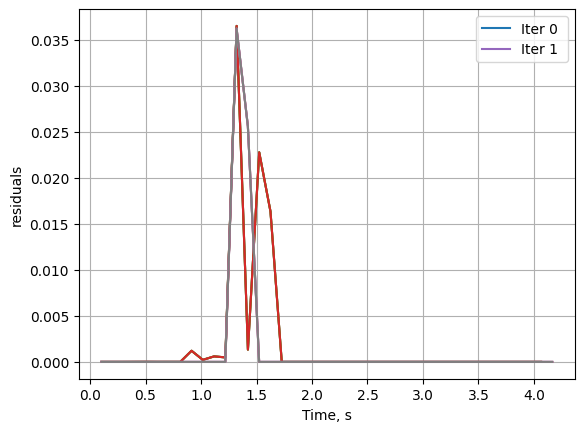

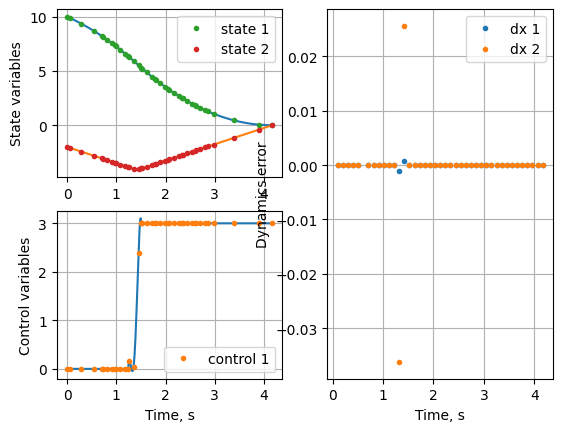

In [36]:
mpo = mp.mpopt_h_adaptive(ocp, 10, 4) # Use ctrl + tab for help, inside ()
mpo.plot_residual_evolution = True
max_iter = 2
solution = mpo.solve(max_iter=max_iter, mpopt_options={'method':'residual', 'sub_method':'equal_area'})
post = mpo.process_results(solution, plot=True)

Notice that the residual is reduced by concentrating the nodes close to the discontinuity.

The terminal free time in this case is given below

In [37]:
print(f"\nTerminal time using Adaptive-II scheme-2 with +{max_iter-1} iterations , s : {post.get_data()[-2][-1][0]} vs 4.1641")


Terminal time using Adaptive-II scheme-2 with +1 iterations , s : 4.164738266741216 vs 4.1641


## Adaptive schem-III : Direct optimization

The third scheme solves for the optimal segment widths along with the original OCP itself.
Hence, no iterative procedure is involved. 

For the moon lander problem with one disconitnuiy,one needs only 3 segments to get the exact thrust profile. Further, being bang bang profile, the thrust is constant at both corners. 

Let's use only 3 segments and minimum order polynomials to capture the solution to check the effectiveness of the method

Initialize the optimizer

In [38]:
mpo = mp.mpopt_adaptive(ocp, 3, 2) # Use ctrl + tab for help, inside ()
mpo.mid_residuals=True

Solve the NLP and process the results

Optimal segment width fractions: [0.31820188 0.03099379 0.65080433]

 Post processed in 21.747 ms
 	 Solution retrieval            : 0.146 ms
 	 Residual in dynamics           : 2.102 ms
 	 Process solution and plot      : 19.499 ms


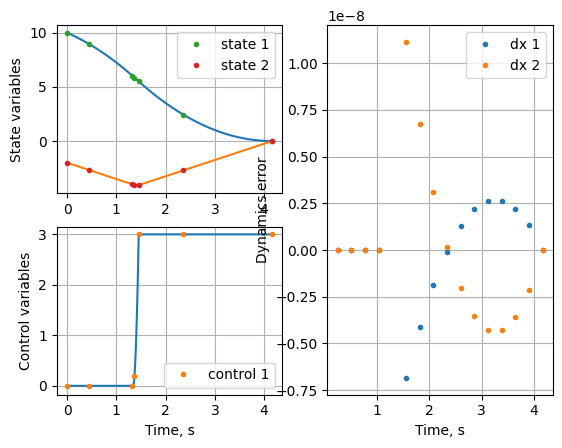

In [39]:
solution = mpo.solve()
post = mpo.process_results(solution, plot=True)

Notice that the middle segment width is 0.03. That is the default minimu width of the segment implemented in the method. Let's reduce the minimum allowed segment width to 1e-6 and resolve the problem.

In [40]:
mpo = mp.mpopt_adaptive(ocp, 3, 2) # Use ctrl + tab for help, inside ()
mpo.lbh[0] = 1e-6

Optimal segment width fractions: [2.62292233e-06 9.29740025e-01 7.02573521e-02]

 Post processed in 23.777 ms
 	 Solution retrieval            : 0.109 ms
 	 Residual in dynamics           : 2.372 ms
 	 Process solution and plot      : 21.295 ms


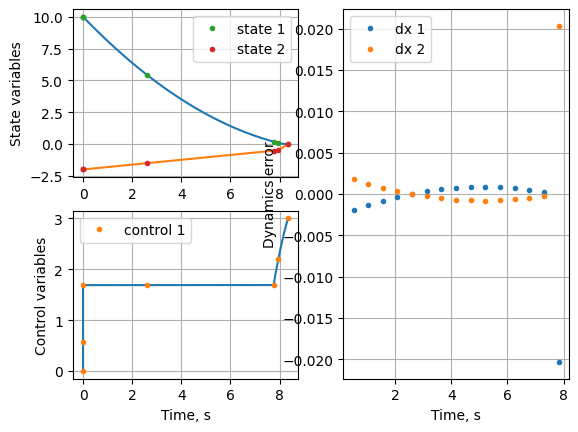

In [41]:
solution = mpo.solve()
post = mpo.process_results(solution, plot=True)

Notice that the discontinuity is exactly captured using the method with minimum possible collocation nodes.

In [42]:
print(f"\nTerminal time using Adaptive scheme-III , s : {post.get_data()[-2][-1][0]} vs 4.1641")


Terminal time using Adaptive scheme-III , s : 8.3414904388322 vs 4.1641


Let's check the robustness of the method by increasing the number of segments

Optimal segment width fractions: [3.39881653e-01 1.43712770e-05 1.40014871e-05 1.48705948e-05
 6.60075103e-01]

 Post processed in 26.976 ms
 	 Solution retrieval            : 0.119 ms
 	 Residual in dynamics           : 3.358 ms
 	 Process solution and plot      : 23.498 ms


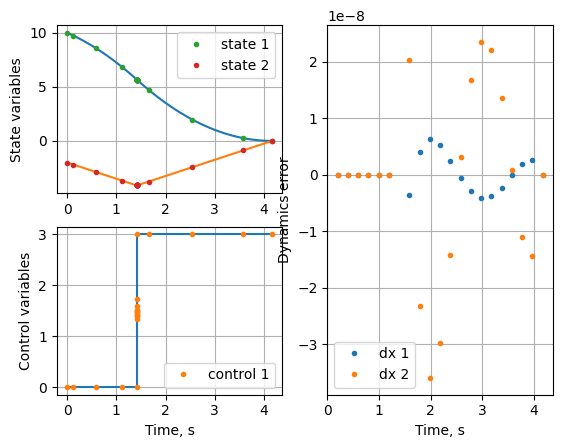

In [43]:
mpo = mp.mpopt_adaptive(ocp, 5, 4) # Use ctrl + tab for help, inside ()
mpo.lbh[0] = 1e-6
solution = mpo.solve()
post = mpo.process_results(solution, plot=True)

Notice that the time taken by the algorithm is significantly higher compared to iterative schemes. However, the solution is accurate using the Adaptive scheme-III.

## Conclusion

Using simple moon-lander test case OCP various features of the solver package in its current form are demonstrated. Notice that the OCP is defined only once in the beginning. This sheet can be used for all other OCP's merely by changing the OCP definition in the beginning.